# Covid Object Detection from X-Ray Images using YOLOv4 and YOLOv5
Pandega Abyan Zumarsyah (18/424977/TK/46672)

-----

### Dataset
Data yang digunakan berasal dari kaggle: [SIIM-FISABIO-RSNA COVID-19 Detection](https://www.kaggle.com/c/siim-covid19-detection/overview). Namun, data itu berbentuk file dicom, berukuran sangat besar, dan tidak dapat diakses dengan mudah. Untungnya, telah ada beberapa pihak yang membuat akses datanya menjadi lebih mudah. Saya akhirnya menggunakan data [SIIM COVID-19: Resized to 256px JPG](https://www.kaggle.com/xhlulu/siim-covid19-resized-to-256px-jpg) untuk citranya dan data [SIIM-COVID-19 Detection Training Labels](https://www.kaggle.com/ammarnassanalhajali/siimcovid19-detection-training-label) untuk label/anotasinya. 

### Kode
Pada kaggle, sebenarnya sudah ada banyak kode yang menggunakan dataset SIIM-FISABIO-RSNA COVID-19 karena memang itu adalah kompetisi berhadiah besar. Saya pun belajar banyak dengan melihat berbagai kode yang ada, terutama terkait konversi label agar sesuai format YOLO. Kode utama yang saya jadikan referensi adalah [COVID-19 Detection YOLOv5 3Classes](https://https://www.kaggle.com/ammarnassanalhajali/covid-19-detection-yolov5-3classes-training/notebook). Dari kode itu, saya menghilangkan beberapa hal yang tidak penting dan menambahkan hal baru, seperti penambahan untuk test data. Bahkan, ada juga kesalahan fatal pada kode aslinya, yaitu ketika membuat konversi label. 

### Model
Ada dua model yang digunakan, yaitu YOLOv4 dan YOLOv5. Untuk YOLOv5, saya menggunakan repo asli yang ada di Github, yaitu https://github.com/ultralytics/yolov5. Untuk YOLOv4, repo aslinya masih relatif sederhana dan tidak memiliki banyak fitur. Karenanya, saya menggunakan repo yang mirip dengan repo asli YOLOv5 dan dapat diimplementasikan langsung di PyTorch, yaitu https://github.com/WongKinYiu/PyTorch_YOLOv4/tree/u5. Keduanya cukup mirip dan format pelabelannya pun sama. Dengan begitu, harapannya keduanya bisa dibandingkan dengan lebih tepat. Namun, tidak bisa dipungkiri bahwa repo asli YOLOv5 jauh lebih advanced dari repo modifikasi YOLOv4. 

### Alur Pengujian
Pengujian diawali dengan pengolahan data, yaitu citra dan labelnya, agar bisa sesuai dengan format YOLO. Setelah itu, dijalankanlah training pada model. Ketika training, berbagai statistik akan tercatat secara otomatis. Setelah itu, terdapat evaluasi untuk melihat performa ketika training dan untuk menguji model menggunakan data test. Pada bagian akhir, terdapat pembandingan beberapa statistik dari beberapa pengujian yang telah dilakukan. 



## Initialization
---
Bagian ini meliputi import library, koneksi ke Google Drive dan copy file dari sana, serta koneksi ke WandB. WandB sendiri merupakan platform untuk membantu mendokumentasikan proses training dari model dengan lebih nyaman, ini sudah built-in di YOLOv5. 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os
import cv2

from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

In [2]:
!pip install -U PyYAML # yaml module in Colab is not suitable so that we need to install the new one
import yaml

     |████████████████████████████████| 596 kB 5.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 1.9.0+cu111 (Tesla K80)


### Connect to Google Drive

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# copy label file
!cp '/content/gdrive/My Drive/Project TNF - Covid Object Segmentation/Dataset/train_image_df.csv' '/content/'

# copy compressed image files and extract it
!cp '/content/gdrive/My Drive/Project TNF - Covid Object Segmentation/Dataset/SIIM COVID-19 Resized to 256px JPG.zip' '/content/'
!unzip '/content/SIIM COVID-19 Resized to 256px JPG.zip' > /dev/null

## Data Preparation
---
Bagian ini meliputi loading file label sebagai Dataframe, penyesuaian kelas pada Dataframe, split menjadi train-val-test, dan lainnya. Setelah itu, setiap citra ditaruh di folder sesuai pembagian train-val-test sebelumnya. Pada bagian ini, disiapkan pula file yaml, train.txt, val.txt, test.txt, dan berbagai file untuk label. Penyiapan file untuk label itu tidaklah mudah karena harus sesuai format YOLO yang memang agak rumit. 

Yang perlu diperhatikan di sini, satu citra dapat memiliki beberapa label. Maka, perlu dibedakan antara Dataframe yang memuat citra dan alamatnya (berguna untuk mengelola file citra sesuai format YOLO) dan Dataframe yang memuat label (berguna untuk membuat file label sesuai format YOLO). Splitting pun dilakukan pada Dataframe citra agar tidak ada citra yang sama pada train-val-test.

### Load Dataset

In [6]:
# Load label file as Dataframe
df = pd.read_csv('/content/train_image_df.csv')

# Add absolute path to the Dataframe
df['path'] = df.apply(lambda row: '/content/train/'+row.id+'.jpg', axis=1)

# Preview
df

id  ...                             path
0     000a312787f2  ...  /content/train/000a312787f2.jpg
1     000a312787f2  ...  /content/train/000a312787f2.jpg
2     000c3a3f293f  ...  /content/train/000c3a3f293f.jpg
3     0012ff7358bc  ...  /content/train/0012ff7358bc.jpg
4     0012ff7358bc  ...  /content/train/0012ff7358bc.jpg
...            ...  ...                              ...
9888  ffd9b6cf2961  ...  /content/train/ffd9b6cf2961.jpg
9889  ffdc682f7680  ...  /content/train/ffdc682f7680.jpg
9890  ffdc682f7680  ...  /content/train/ffdc682f7680.jpg
9891  ffe942c8655f  ...  /content/train/ffe942c8655f.jpg
9892  ffe942c8655f  ...  /content/train/ffe942c8655f.jpg

[9893 rows x 23 columns]

In [7]:
# Label Counts
df['integer_label'].value_counts()

3    6034
2    1736
1    1494
0     629
Name: integer_label, dtype: int64

### Classes

In [8]:
# Delete label 2 then change label 3 into 2
# that's because label 2 has no bounding box so we don't need to use it
df = df[df.integer_label!=2].reset_index(drop = True)
df["integer_label"] = df["integer_label"].replace(3,2)

In [9]:
# get classes name as sorted list variable
class_dict = sorted(set(zip(df.integer_label, df.y_label)))
classes = [x[1] for x in class_dict]
classes

['atypical', 'indeterminate', 'typical']

### Reduce Dataset

In [10]:
# Drop some rows
#index_to_drop = df[df.integer_label == 2].index[2500:]
#df = df.drop(index_to_drop).reset_index(drop = True)

# Used dataset
#unused_df, used_df = train_test_split(df, test_size=0.3, random_state=15, stratify=df.integer_label.values)
#df = used_df.copy()

### Splitting Dataset

In [11]:
# Use the Dataframe that has no id duplicates
df_full = df.copy()
df = df.drop_duplicates(subset=['id']).reset_index(drop = True)

In [12]:
# Create train, validation, test data
train_df, valtest_df = train_test_split(df, test_size=0.3, random_state=15, stratify=df.integer_label.values)
df = valtest_df.copy()
valid_df, test_df = train_test_split(df, test_size=0.5, random_state=15, stratify=df.integer_label.values)

# Add data label
train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'
test_df.loc[:, 'split'] = 'test'

# Combine train, validation, test into single Dataframe
df = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
print(f'Size of dataset: {len(df)} images, train: {len(train_df)} val: {len(valid_df)} test: {len(test_df)}. ')

Size of dataset: 4598 images, train: 3218 val: 690 test: 690. 


### Organizing Directories

In [14]:
os.makedirs('covid19/images/train', exist_ok=True)
os.makedirs('covid19/images/valid', exist_ok=True)
os.makedirs('covid19/images/test', exist_ok=True)
os.makedirs('covid19/labels/train', exist_ok=True)
os.makedirs('covid19/labels/valid', exist_ok=True)
os.makedirs('covid19/labels/test', exist_ok=True)

In [15]:
# Move the images to relevant split folder
for i in tqdm(range(len(df))):
    row = df.loc[i]
    if row.split == 'train':
        shutil.copyfile(row.path, f'covid19/images/train/{row.id}.jpg')
    elif row.split == 'valid':
        shutil.copyfile(row.path, f'covid19/images/valid/{row.id}.jpg')
    else:
        shutil.copyfile(row.path, f'covid19/images/test/{row.id}.jpg')

100%|██████████| 4598/4598 [00:02<00:00, 2084.90it/s]


In [16]:
# delete unused folder to save storage
!rm -rf /content/train
!rm -rf /content/test

### Create yaml file

In [17]:
# create dictionary to be exported to yaml file
data = dict(
    train = '/content/covid19/images/train',
    val   = '/content/covid19/images/valid',
    test   = '/content/covid19/images/test',
    nc    = 3, # number of classes
    names = classes # classes
    )

# create yaml file
with open('/content/covid19.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

# read the yaml file
f = open('/content/covid19.yaml', 'r')
print(f.read())

names:
- atypical
- indeterminate
- typical
nc: 3
test: /content/covid19/images/test
train: /content/covid19/images/train
val: /content/covid19/images/valid



### Create train.txt val.txt test.txt

In [18]:
with open('/content/covid19/train.txt', 'w') as f:
    for path in glob('/content/covid19/images/train/*'):
        f.write(path+'\n')
            
with open('/content/covid19/val.txt', 'w') as f:
    for path in glob('/content/covid19/images/valid/*'):
        f.write(path+'\n')

with open('/content/covid19/test.txt', 'w') as f:
    for path in glob('/content/covid19/images/test/*'):
        f.write(path+'\n')

### Create labels

In [19]:
def get_yolo_bbox(img_w, img_h, row):
    # get bounding box from Dataframe as list of lists
    bboxes = []
    bbox = []
    label = row.integer_label
    b1=row.x_min
    b2=row.y_min
    b3=row.x_max
    b4=row.y_max
    bbox.append(label)
    bbox.append(float(b1))
    bbox.append(float(b2))
    bbox.append(float(b3))
    bbox.append(float(b4))
    bboxes.append(bbox)

    # scale the bounding box to match predefined image size
    scale_x = img_w/row.width
    scale_y = img_h/row.height
    scaled_bboxes = []
    for bbox in bboxes:
        x = float(bbox[1]*scale_x)
        y = float(bbox[2]*scale_y)
        x1 = float(bbox[3]*(scale_x))
        y1= float(bbox[4]*scale_y)
        scaled_bboxes.append([bbox[0], x, y, x1, y1])

    # recalculate the bounding box to match YOLO format
    yolo_boxes = []
    for bbox in scaled_bboxes:
        w = bbox[3] - bbox[1] # xmax - xmin
        h = bbox[4] - bbox[2] # ymax - ymin
        xc = bbox[1] + float(w/2) # xmin + width/2
        yc = bbox[2] + float(h/2) # ymin + height/2
        yolo_boxes.append([bbox[0], xc/img_w, yc/img_h, w/img_w, h/img_h])
                         # label   x_center  y_center  width    height   (normalized)
    return yolo_boxes

In [20]:
for i in tqdm(df.index):
    # Get row of df
    row = df.loc[i]
    # Get image id
    img_id = row.id
    # Get split
    split = row.split
    # Define path based on split type
    if row.split=='train':
        file_name = f'covid19/labels/train/{row.id}.txt'
    elif row.split=='valid':
        file_name = f'covid19/labels/valid/{row.id}.txt'
    else:
        file_name = f'covid19/labels/test/{row.id}.txt'
    # Subset of full Dataframe that contain only specific id
    df_sub = df_full[df_full.id == row.id]
    # Create labels
    with open(file_name, 'w') as f:
        for j in range(len(df_sub)):
            row_sub = df_sub.iloc[j]
            yolo_bboxes = get_yolo_bbox(256, 256, row_sub)
            for bbox in yolo_bboxes:
                # write line by line
                bbox = [str(i) for i in bbox]
                bbox = ' '.join(bbox)
                f.write(bbox)
                f.write('\n')

100%|██████████| 4598/4598 [00:09<00:00, 469.81it/s]


## YOLOv5
---
YOLOv5 ini diambil dari repository https://github.com/ultralytics/yolov5. Ketika melakukan training atau evaluasi, terdapat banyak data dan gambar plot yang disimpan secara otomatis sehingga bisa ditampilkan kembali dengan mudah. YOLOv5 ini juga terkoneksi dengan WandB (https://wandb.ai/) sehingga datanya dapat terdokumentasi dengan baik. 

### Login WandB

In [21]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 180 kB 48.4 MB/s 
     |████████████████████████████████| 139 kB 51.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [22]:
# login using your own WandB account
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Download Model

In [23]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo

# install dependencies
%cd yolov5
%pip install -qr requirements.txt
%cd ../

Cloning into 'yolov5'...
remote: Enumerating objects: 9829, done.
remote: Counting objects: 100% (9829/9829), done.
remote: Compressing objects: 100% (2976/2976), done.
remote: Total 9829 (delta 6840), reused 9829 (delta 6840), pack-reused 0
Receiving objects: 100% (9829/9829), 10.06 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (6840/6840), done.
/content/yolov5
/content


### Train Model

In [24]:
# copy yaml file containing the data config
!cp '/content/covid19.yaml' '/content/yolov5/data'

In [25]:
%cd yolov5

/content/yolov5


Kita bisa melakukan train dengan memanfaatkan pre-trained weight (yaitu melalui file weight .pt) atau dengan model yang masih kosong (yaitu melalui file config .yaml). Bahkan, kita juga bisa mengedit file .yaml dengan mudah untuk mengubah struktur layernya, misalnya pada file berikut: /content/yolov5/models/yolov5s.yaml

In [26]:
# train without pre-trained weight
!python train.py --img-size 256 \
                 --batch 32 \
                 --epochs 5 \
                 --data covid19.yaml \
                 --cfg yolov5s.yaml \
                 --weights '' \
                 --project siim-covid19-detect-2 \
                 --cache

wandb: Currently logged in as: pandegaaz (use `wandb login --relogin` to force relogin)
train: weights=, cfg=yolov5s.yaml, data=covid19.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=32, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=siim-covid19-detect-2, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anch

In [ ]:
# train with pre-trained weight
!python train.py --img-size 256 \
                 --batch 32 \
                 --epochs 100 \
                 --data covid19.yaml \
                 --weights yolov5s.pt \
                 --project siim-covid19-detect-3 \
                 --cache

In [ ]:
# Copy the result
#!cp -av '/content/yolov5/siim-covid19-detect-3/exp' '/content/gdrive/MyDrive/Project TNF - Covid Object Segmentation/temp train result' > /dev/null

In [ ]:
%cd ../

/content


### Result

#### Class Distribution

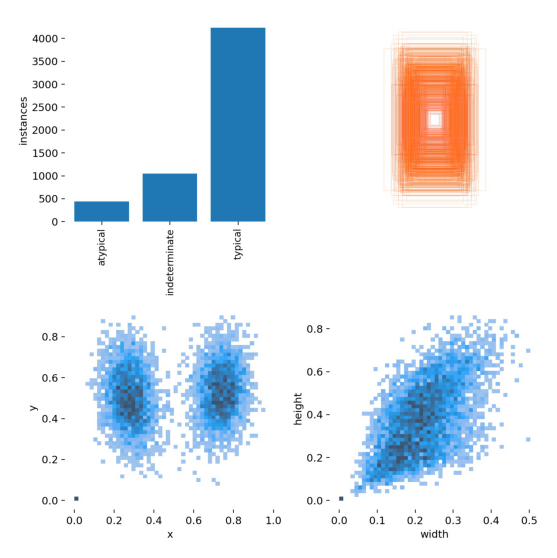

In [ ]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('./yolov5/siim-covid19-detect-3/exp/labels.jpg'));

#### Batch Image

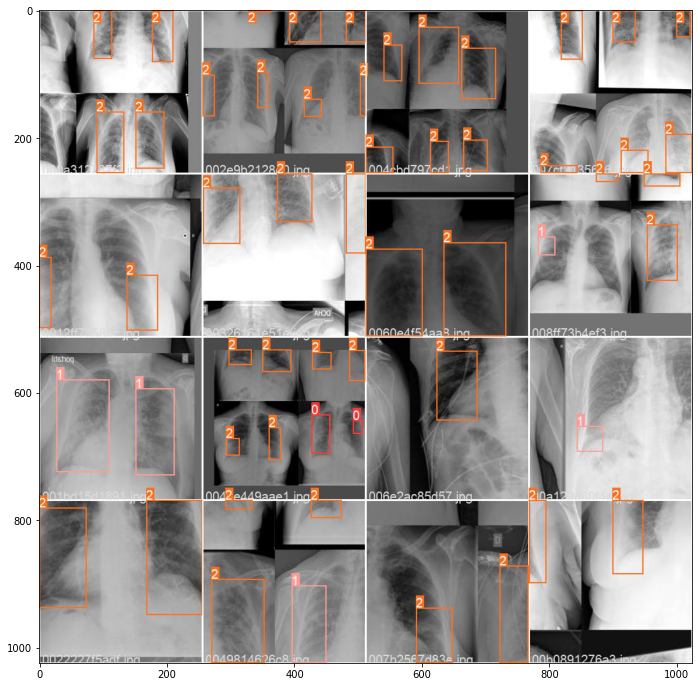

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 12))
plt.imshow(plt.imread('./yolov5/siim-covid19-detect-3/exp/train_batch0.jpg'))

#### P Curve

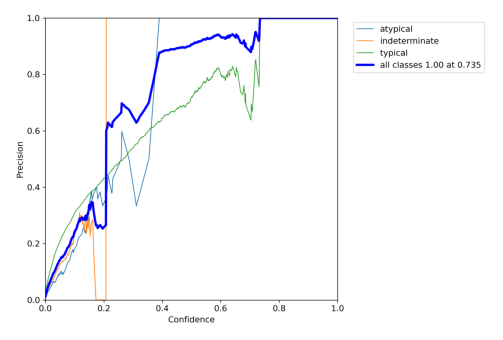

In [ ]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(plt.imread('/content/yolov5/siim-covid19-detect-3/exp/P_curve.png'));

#### R Curve

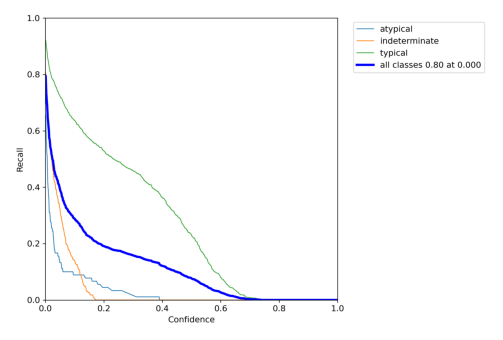

In [ ]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(plt.imread('/content/yolov5/siim-covid19-detect-3/exp/R_curve.png'));

#### PR Curve

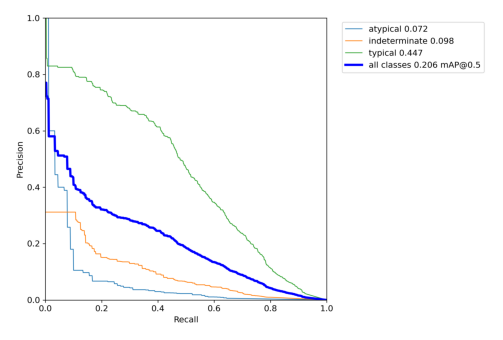

In [ ]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(plt.imread('/content/yolov5/siim-covid19-detect-3/exp/PR_curve.png'));

#### F1 Curve

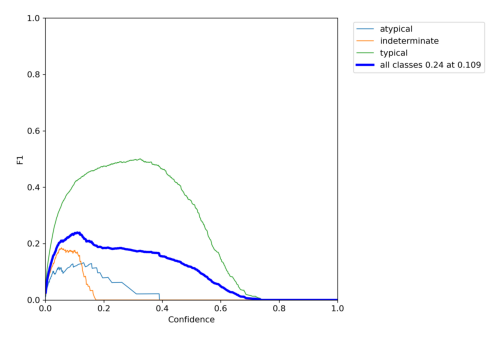

In [ ]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(plt.imread('/content/yolov5/siim-covid19-detect-3/exp/F1_curve.png'));

#### Result vs Epoch

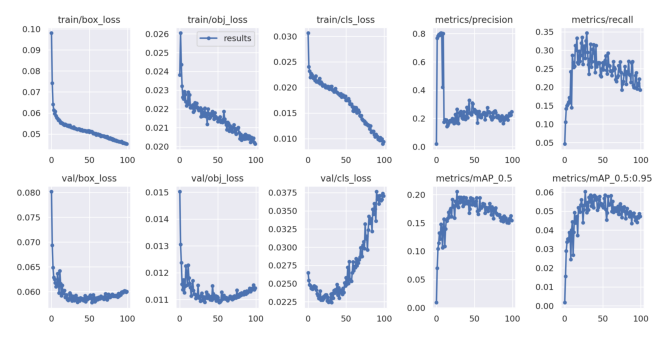

In [ ]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(plt.imread('./yolov5/siim-covid19-detect-3/exp/results.png'));

### Inference

In [ ]:
# copy yaml file containing the data config
#!cp '/content/covid19.yaml' '/content/yolov5/data'

In [27]:
# Copy weight from Google Drive to Colab

!cp '/content/gdrive/MyDrive/Project TNF - Covid Object Segmentation/train-result/exp2/weights/best.pt' \
    '/content/yolov5/'

In [28]:
%cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/content/yolov5


In [29]:
# Evaluate the trained model using test data
!python val.py --weights '/content/yolov5/best.pt' \
               --data covid19.yaml \
               --task 'test' \
               --img-size 256 \
               --conf 0.1 \
               --iou-thres 0.5 \
               --augment \
               --save-txt

val: data=/content/yolov5/data/covid19.yaml, weights=['/content/yolov5/best.pt'], batch_size=32, imgsz=256, conf_thres=0.1, iou_thres=0.5, task=test, device=, single_cls=False, augment=True, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/covid19/labels/test' images and labels...690 found, 0 missing, 0 empty, 0 corrupted: 100% 690/690 [00:00<00:00, 1788.68it/s]
test: New cache created: /content/covid19/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 22/22 [00:12<00:00,  1.70it/s]
                 all        690       1220      0.231      0.243      0.196     0.0663
            atypical        690         96        0.1      0.104     0.0668     0.

In [ ]:
# Copy the result
#!cp -av '/content/yolov5/runs/val/exp' '/content/gdrive/MyDrive/Project TNF - Covid Object Segmentation/temp test result' > /dev/null

In [31]:
# Object Detection for images in the test data using the trained model
!python detect.py --weights '/content/yolov5/best.pt' \
                  --source '/content/covid19/images/test/' \
                  --img-size 256 \
                  --conf 0.25 \
                  --iou-thres 0.5 \
                  --augment \
                  --save-txt

detect: weights=['/content/yolov5/best.pt'], source=/content/covid19/images/test/, imgsz=[256, 256], conf_thres=0.25, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/690 /content/covid19/images/test/001398f4ff4f.jpg: 256x256 Done. (0.073s)
image 2/690 /content/covid19/images/test/00b767b49fcd.jpg: 256x256 1 atypical, Done. (0.075s)
image 3/690 /content/covid19/images/test/010a18b0c868.jpg: 256x256 2 typicals, Done. (0.071s)
image 4/690 /content/covid19/images/test/01a1aabbef0d.jpg: 256x256 1 atypical, Done. (0.071s)
image 5/690 /content/covid19/im

In [37]:
%cd ../

/content


### Inference Plot

#### GT vs Prediction

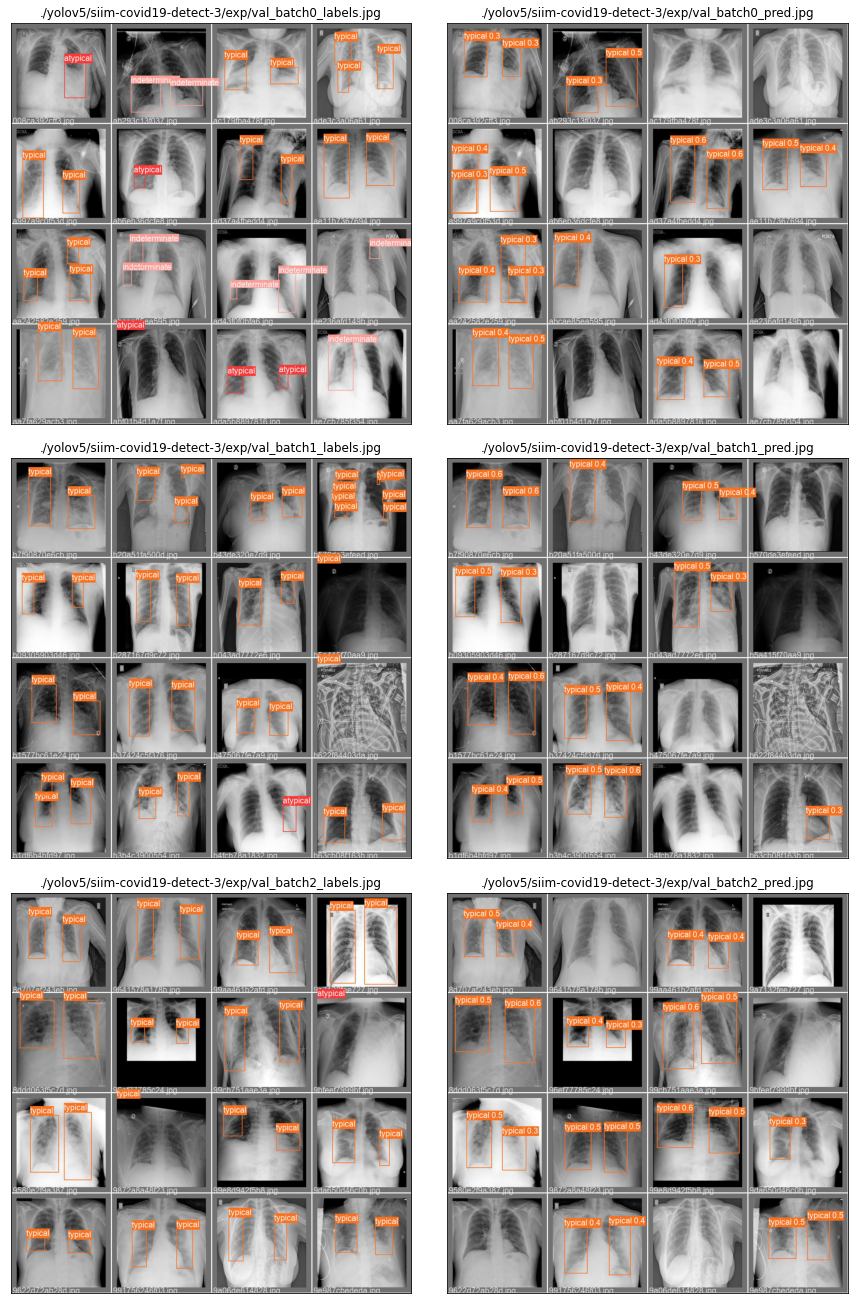

In [ ]:
ig, ax = plt.subplots(3, 2, figsize = (2*6,3*6), constrained_layout = True)
for row in range(3):
  
    ax[row][0].imshow(plt.imread(f'/content/yolov5/runs/val/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/content/yolov5/runs/val/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/content/yolov5/runs/val/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/content/yolov5/runs/val/exp/val_batch{row}_pred.jpg', fontsize = 12)

#### Detection Result

100%|██████████| 10/10 [00:00<00:00, 548.32it/s]


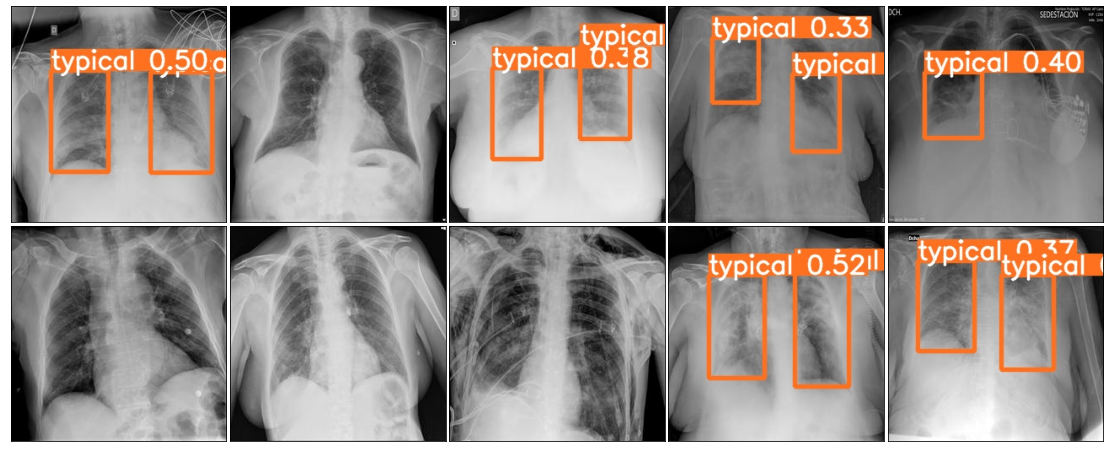

100%|██████████| 10/10 [00:00<00:00, 458.44it/s]


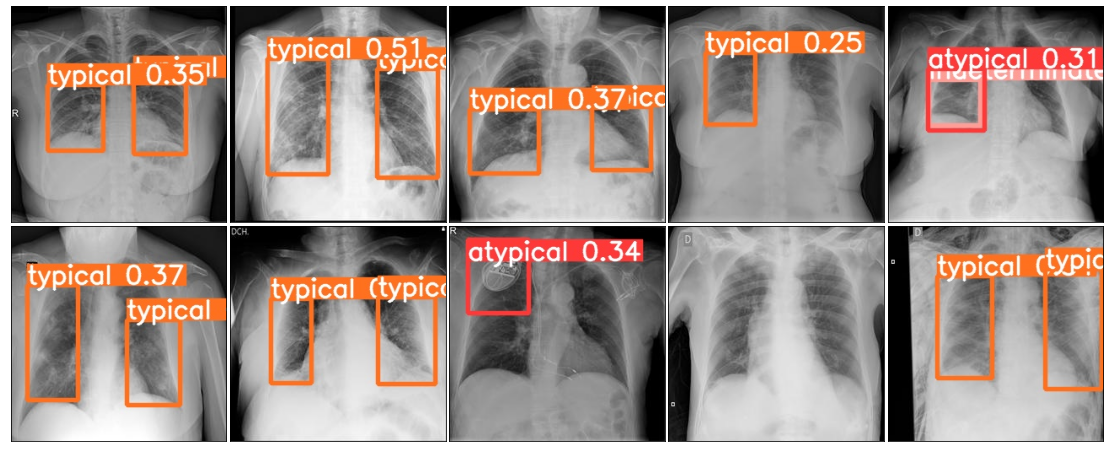

In [42]:
from mpl_toolkits.axes_grid1 import ImageGrid
import random

files = glob('/content/yolov5/runs/detect/exp2/*')
for _ in range(2):
    row = 2
    col = 5
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img= cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*4, row*4))
    grid = ImageGrid(fig, 111, nrows_ncols=(row, col), axes_pad=0.05)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

## YOLOv4
---
YOLOv4 ini diambil dari https://github.com/WongKinYiu/PyTorch_YOLOv4/tree/u5, yaitu branch u5 dari repository PyTorch_YOLOv4. Penggunaannya cukup mirip dengan repository YOLOv5, namun perekaman proses dan hasilnya tidak sebanyak itu. Sebelumnya, kita perlu menginstal mish-cuda dari repository https://github.com/thomasbrandon/mish-cuda Repository ini juga relatif kurang stabil dibanding YOLOv5. 

### Install mish-cuda

In [21]:
# Download mish-cuda
!git clone https://github.com/thomasbrandon/mish-cuda

# Install mish-cuda
%cd mish-cuda
!python setup.py build install
%cd ../

Cloning into 'mish-cuda'...
remote: Enumerating objects: 107, done.
remote: Total 107 (delta 0), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (107/107), 52.89 KiB | 1.15 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/mish-cuda
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/mish_cuda
copying src/mish_cuda/__init__.py -> build/lib.linux-x86_64-3.7/mish_cuda
running egg_info
creating src/mish_cuda.egg-info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.txt
writing manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:370: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow

### Download Model

In [22]:
# Download YOLOv4
!git clone --branch u5 --single-branch https://github.com/WongKinYiu/PyTorch_YOLOv4

Cloning into 'PyTorch_YOLOv4'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 262 (delta 6), reused 4 (delta 4), pack-reused 255
Receiving objects: 100% (262/262), 1.03 MiB | 6.79 MiB/s, done.
Resolving deltas: 100% (142/142), done.


### Train Model

In [23]:
# copy yaml file containing the data config
!cp '/content/covid19.yaml' '/content/PyTorch_YOLOv4/data'

In [24]:
%cd PyTorch_YOLOv4

/content/PyTorch_YOLOv4


Sebelumnya, kita perlu melakukan debug pada file yolo.py di baris 131-132 menjadi seperti di bawah: 

/content/PyTorch_YOLOv4/models/yolo.py 

            b[:, 4].data += math.log(8 / (640 / s) ** 2)  # obj (8 objects per 640 image)
            b[:, 5:].data += math.log(0.6 / (m.nc - 0.99)) if cf is None else torch.log(cf / cf.sum())  # cls

---
Kita bisa melakukan train dengan memanfaatkan pre-trained weight (yaitu melalui file weight .pt) atau dengan model yang masih kosong (yaitu melalui file config .yaml). Bahkan, kita juga bisa mengedit file .yaml dengan mudah untuk mengubah struktur layernya, misalnya pada file berikut: /content/PyTorch_YOLOv4/models/yolov4s-mish.yaml

In [29]:
!python train.py --img 256 \
                 --batch-size 32 \
                 --epochs 5 \
                 --data covid19.yaml \
                 --cfg yolov4s-mish.yaml \
                 --weights '' \
                 --name yolov4s-mish

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Namespace(batch_size=32, bucket='', cache_images=False, cfg='./models/yolov4s-mish.yaml', data='./data/covid19.yaml', device='', epochs=5, evolve=False, hyp='', img_size=[256, 256], local_rank=-1, multi_scale=False, name='yolov4s-mish', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=32, weights='', world_size=1)
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
Hyperparameters {'optimizer': 'SGD', 'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Overriding ./models/yolov4s-mish.yaml nc=80 

In [59]:
# Copy the result
#!cp -av '/content/PyTorch_YOLOv4/runs/exp_yolov4s-mish' '/content/gdrive/MyDrive/Project TNF - Covid Object Segmentation/train-result'  > /dev/null

In [33]:
%cd ../

/content


### Result

#### Class Distribution

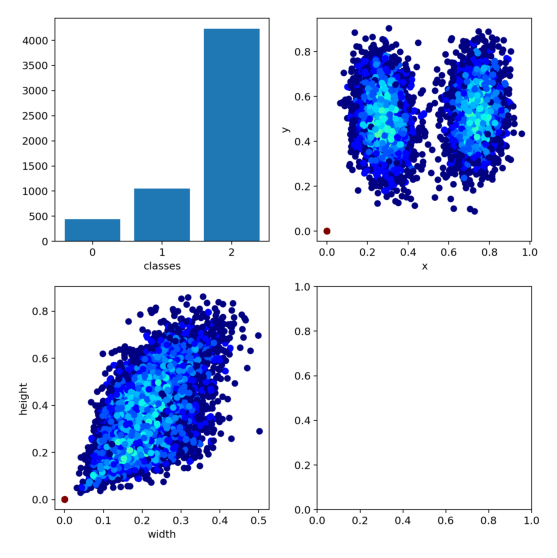

In [34]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('./PyTorch_YOLOv4/runs/exp_yolov4s-mish/labels.png'));

#### Batch Image

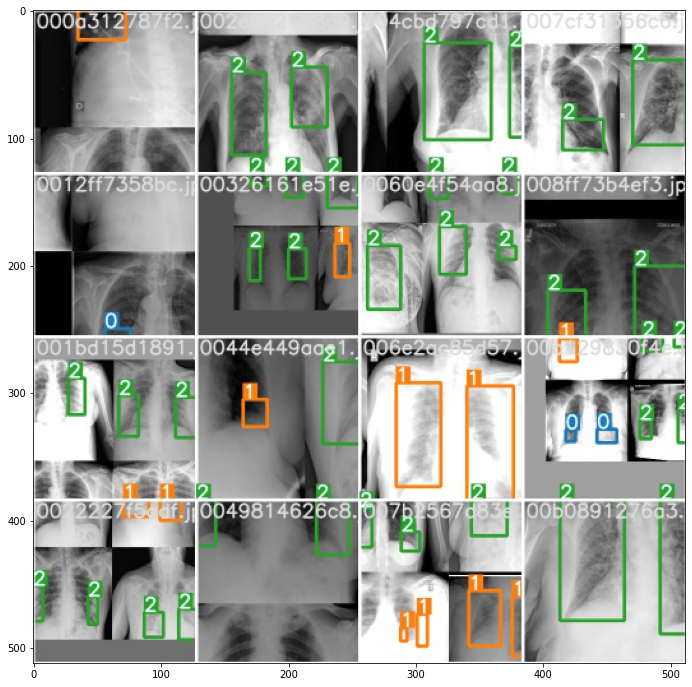

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 12))
plt.imshow(plt.imread('./PyTorch_YOLOv4/runs/exp_yolov4s-mish/train_batch0.jpg'))

#### Result vs Epoch

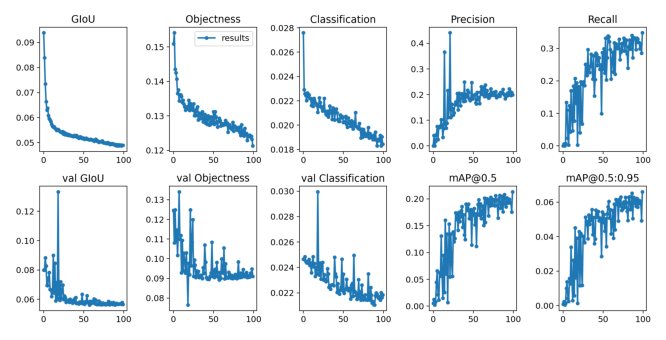

In [36]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(plt.imread('./PyTorch_YOLOv4/runs/exp_yolov4s-mish/results.png'));

### Inference

In [57]:
# copy yaml file containing the data config
#!cp '/content/covid19.yaml' '/content/PyTorch_YOLOv4/data'

In [26]:
# Copy weight from Google Drive to Colab

!cp '/content/gdrive/MyDrive/Project TNF - Covid Object Segmentation/train-result/exp_yolov4s-mish/weights/best_yolov4s-mish.pt' \
    '/content/PyTorch_YOLOv4/'

In [55]:
%cd PyTorch_YOLOv4

[Errno 2] No such file or directory: 'PyTorch_YOLOv4'
/content/PyTorch_YOLOv4


In [27]:
# Evaluate the trained model using test data
!python test.py --weights 'best_yolov4s-mish.pt' \
                --data covid19.yaml \
                --task 'test' \
                --img-size 256 \
                --conf 0.1 \
                --iou-thres 0.5 \
                --augment \
                --save-txt

Namespace(augment=True, batch_size=32, conf_thres=0.1, data='./data/covid19.yaml', device='', img_size=256, iou_thres=0.5, merge=False, save_json=False, save_txt=True, single_cls=False, task='test', verbose=False, weights=['best_yolov4s-mish.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Fusing layers... Using CPU

Model Summary: 163 layers, 9.11218e+06 parameters, 8.59077e+06 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Scanning images: 100% 690/690 [00:00<00:00, 4774.79it/s]
Scanning labels /content/covid19/labels/test.cache (690 found, 0 missing, 0 empty, 0 duplicate, for 690 imag

In [44]:
# Object Detection for images in the test data using the trained model
!python detect.py --weights 'runs/exp_yolov4s-mish/weights/best_yolov4s-mish.pt' \
                  --source '/content/covid19/images/test/' \
                  --img-size 256 \
                  --conf 0.25 \
                  --iou-thres 0.5 \
                  --augment \
                  --save-txt

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.25, device='', img_size=256, iou_thres=0.5, output='inference/output', save_txt=True, source='/content/covid19/images/test/', update=False, view_img=False, weights=['runs/exp5_yolov4s-mish/weights/best_yolov4s-mish.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Fusing layers... Using CPU

Model Summary: 163 layers, 9.11218e+06 parameters, 8.59077e+06 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
image 1/690 /content/covid19/images/test/001398f4ff4f.jpg: 256x256 Done. (0.089s)
image 2/690 /content/covid19/images/tes

In [46]:
%cd ../

/content


### Inference Plot

#### GT vs Prediction

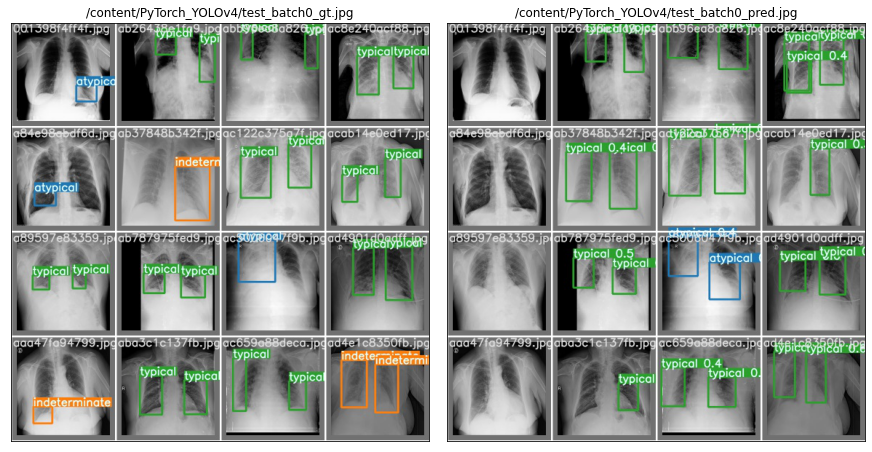

In [56]:
ig, ax = plt.subplots(1, 2, figsize = (2*6,3*6), constrained_layout = True)

ax[0].imshow(plt.imread(f'/content/PyTorch_YOLOv4/test_batch0_gt.jpg'))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'/content/PyTorch_YOLOv4/test_batch0_gt.jpg', fontsize = 12)

ax[1].imshow(plt.imread(f'/content/PyTorch_YOLOv4/test_batch0_pred.jpg'))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f'/content/PyTorch_YOLOv4/test_batch0_pred.jpg', fontsize = 12)

## Comparison
---
Bagian ini membaca berbagai hasil dari pengujian sebelumnya (yaitu dalam file results.csv atau results.txt), kemudian membandingkannya dengan membuat plot. 

### Load Results Data

In [8]:
path_yolov5s_pt = '/content/gdrive/My Drive/Project TNF - Covid Object Segmentation/train-result/exp/results.csv'
path_yolov5s_yaml = '/content/gdrive/My Drive/Project TNF - Covid Object Segmentation/train-result/exp2/results.csv'
path_yolov4s_yaml = '/content/gdrive/My Drive/Project TNF - Covid Object Segmentation/train-result/exp_yolov4s-mish/results.txt'

In [6]:
# Load results.csv from YOLOv5

yolov5s_pt = pd.read_csv(path_yolov5s_pt)
yolov5s_yaml = pd.read_csv(path_yolov5s_yaml)

yolov5s_yaml.tail()

epoch  ...                 x/lr2
0                     0  ...              0.091000
1                     1  ...              0.081910
2                     2  ...              0.072817
3                     3  ...              0.063722
4                     4  ...              0.054622

[5 rows x 14 columns]

In [26]:
# Load results.txt from YOLOv4

col_names = ['Epoch', 'gpu_mem', 'GIoU', 'objectness', 'classification', 'total', 'targets', 'img_size', 
             '   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 
             'val_GIoU', 'val_objectness', 'val_classification']

yolov4s_yaml = pd.read_csv(path_yolov4s_yaml, names=col_names, delim_whitespace=True)

yolov4s_yaml.tail()

Epoch gpu_mem     GIoU  ...  val_GIoU  val_objectness  val_classification
0  0/99   1.14G  0.09386  ...   0.07993          0.1246             0.02466
1  1/99   2.98G  0.08392  ...   0.08000          0.1081             0.02469
2  2/99   2.99G  0.07345  ...   0.08824          0.1249             0.02485
3  3/99   2.99G  0.06638  ...   0.08267          0.1094             0.02448
4  4/99   2.99G  0.06297  ...   0.06959          0.1146             0.02438

[5 rows x 15 columns]

In [32]:
dataframes = [yolov5s_pt, yolov5s_yaml, yolov4s_yaml]
labels = ['yolov5s_pt', 'yolov5s_yaml', 'yolov4s_yaml']

### Plot Metrics

#### Function

In [11]:
def plot_metrics(dataframes, labels, metric):
    plt.figure(figsize=(16, 4))
    for df in dataframes:
        plt.plot(df[metric])
    plt.legend(labels)
    plt.show()

#### Precision

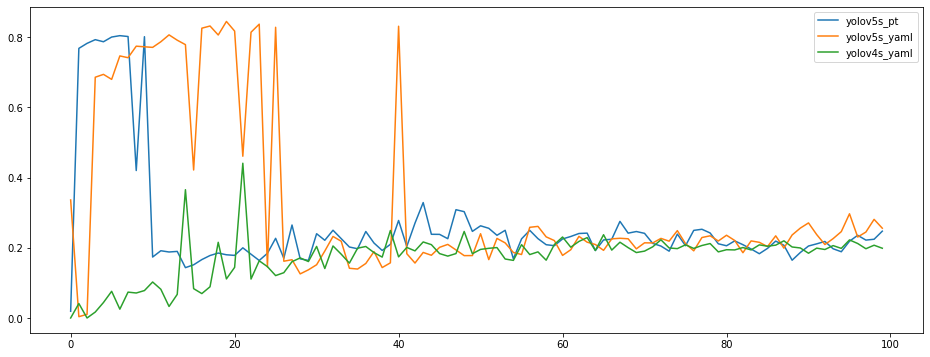

In [33]:
plot_metrics(dataframes, labels, '   metrics/precision')

#### Recall

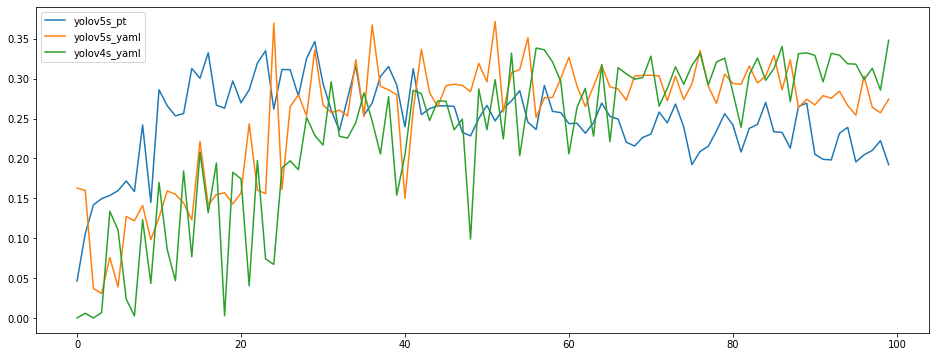

In [34]:
plot_metrics(dataframes, labels, '      metrics/recall')

#### Precision (y) and Recall (x)

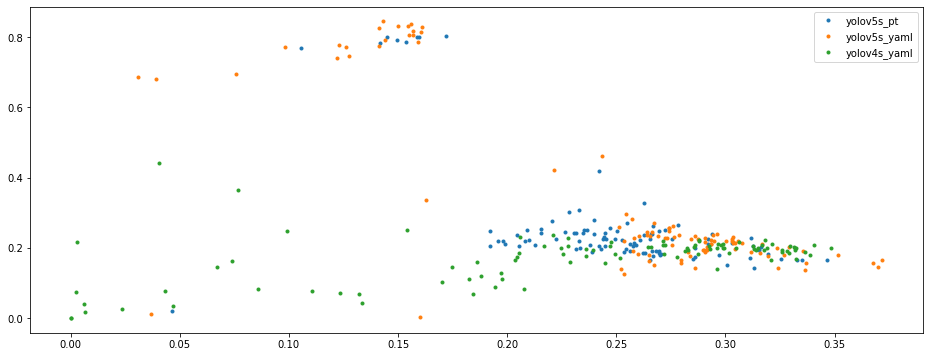

In [42]:
plt.figure(figsize=(16, 6))
for df in dataframes:
    plt.plot(df['      metrics/recall'], df['   metrics/precision'], '.')
plt.legend(labels)
plt.show()

#### mAP 0.5

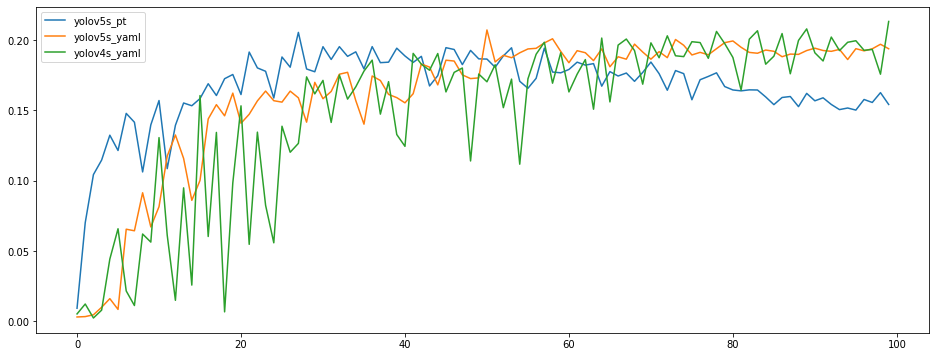

In [35]:
plot_metrics(dataframes, labels, '     metrics/mAP_0.5')

#### mAP 0.5:0.95

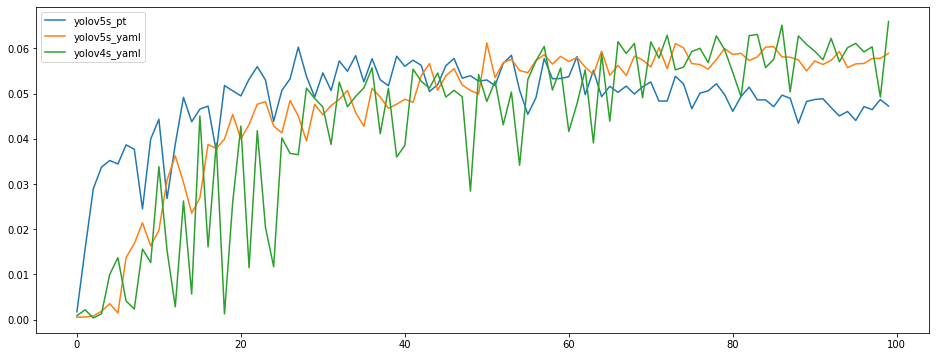

In [16]:
plot_metrics(dataframes, labels, 'metrics/mAP_0.5:0.95')

### Note
Dari proyek ini, hasil yang didapatkan memang masih kurang baik. Nilai dari berbagai metrics yang ada masih terlalu rendah. Ini bisa jadi karena datanya memang tidak mudah untuk dianalisis atau bisa jadi terdapat kesalahan dari kami. 

Bagaimana pun juga, dari proyek ini, kami belajar banyak terkait penggunaan YOLO dan analisisnya. Kode yang dibuat di sini juga bisa menjadi referensi untuk penggunaan YOLO di berbagai keperluan lainnya. 